4 particles found in bin


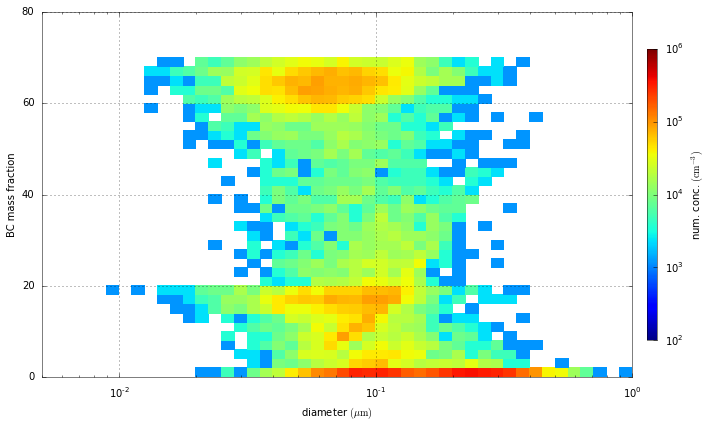

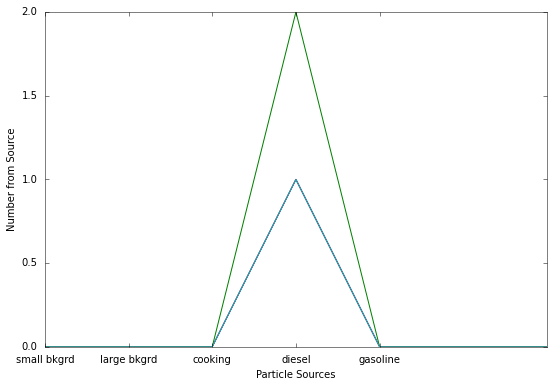

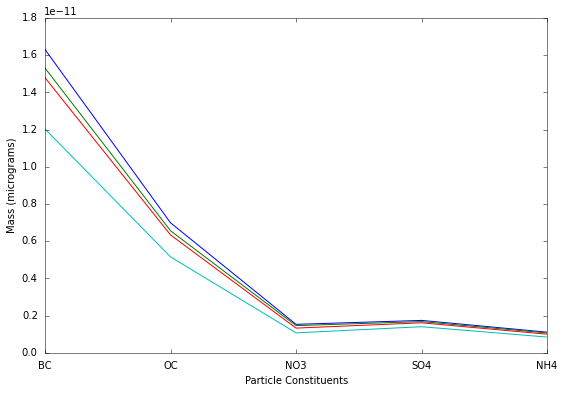

In [61]:
%matplotlib inline
import numpy
import partmc3 as partmc
import scipy
import mpl_helper3 as mpl_helper
import config
import random
import matplotlib
import math
import sys

import matplotlib.pyplot as plt
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.html.widgets.interaction import interact_manual

def grid_box_histogram(time):

    # filename prefix
    dir = config.data_dir
    prefix = config.file_prefix
    filename =  '%s_%08i.nc' %(prefix,time)

    # make grids
    diam_axis = partmc.log_grid(min=1e-9,max=1e-6,n_bin=60)
    bc_axis = partmc.linear_grid(min=0,max=1.,n_bin=50)

    # load the file
    ncf = scipy.io.netcdf.netcdf_file(config.data_dir+'/'+filename, 'r', mmap=False)
    particles = partmc.aero_particle_array_t(ncf)
    ncf.close()

    # compute the values
    bc = particles.masses(include = ["BC"])
    dry_mass = particles.masses(exclude = ["H2O"])
    bc_frac = bc / dry_mass
    dry_diameters = particles.dry_diameters()

    # 2D histogram
    hist_2d_bc = partmc.histogram_2d(dry_diameters, bc_frac, diam_axis, bc_axis,
         weights = 1 / particles.comp_vols)
    # convert
    hist_2d_bc /= 1e6

    # create the figure
    width_in = 10.0
    (figure, axes, cbar_axes) = mpl_helper.make_fig(figure_width=width_in,
        colorbar=True,left_margin=.7,right_margin=1.1, top_margin=0.3,
        bottom_margin=.65, colorbar_height_fraction=0.8)

    # Data min and max
    # we want this to be fixed for all time
    data_min = 10**2 #min(data_mins)
    data_max = 10**6 #max(data_maxes)

    norm = matplotlib.colors.LogNorm(vmin=data_min, vmax=data_max)
    p = axes.pcolormesh(diam_axis.edges()/1e-6, bc_axis.edges()*100, 
        hist_2d_bc.transpose(),norm = norm, linewidths = 0.1, edgecolors='None')

    # make the plot pretty
    axes.set_xscale('log')
    axes.set_yscale('linear')
    xlabel = r'diameter $(\mu \rm m)$'
    ylabel = r'BC mass fraction'
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xlim(.005,1)
    axes.set_ylim(0,80)
    axes.set_yticks([0,20,40,60,80])
    axes.grid(True)

    # colorbar
    cbar = figure.colorbar(p, cax=cbar_axes,
                format=matplotlib.ticker.LogFormatterMathtext(),
                orientation='vertical')
    kwargs = {}
    kwargs["format"] = matplotlib.ticker.LogFormatterMathtext()
    cmappable = matplotlib.cm.ScalarMappable(norm=norm)
    cmappable.set_array(numpy.array([hist_2d_bc.min(), hist_2d_bc.max()]))
    cbar_label = r"num. conc. $(\rm cm^{-3})$"
    cbar.set_label(cbar_label)
    cbar.solids.set_edgecolor("face")

    return

def grid_box_details(x_bin, y_bin, time):
    # filename prefix
    dir = config.data_dir
    prefix = config.file_prefix
    filename =  '%s_%08i.nc' %(prefix,time)

    # Compute the black carbon mass fraction
    x_axis = partmc.log_grid(min=1e-9,max=1e-6,n_bin=60)
    bc_axis = partmc.linear_grid(min=0,max=1.,n_bin=50)

    x_centers = x_axis.centers()
    ncf = scipy.io.netcdf.netcdf_file(config.data_dir+'/'+filename, 'r', mmap=False)
    particles = partmc.aero_particle_array_t(ncf)
    env_state = partmc.env_state_t(ncf)
    aero_data = partmc.aero_data_t(ncf)
    ncf.close()

    bc = particles.masses(include = ["BC"])
    dry_mass = particles.masses(exclude = ["H2O"])
    bc_frac = bc / dry_mass

    dry_diameters = particles.dry_diameters()

    # Find the particles in a certain bin
    x_bins = x_axis.find(dry_diameters)
    y_bins = bc_axis.find(bc_frac)
    #print x_bins[0:10]
    #print y_bins[0:10]
    
    # make figure
    width = 7.0

    # Pick a particle bin
    parts = []
    sources = particles.n_orig_parts
    # this could be better
    x_parts = numpy.ma.masked_not_equal(x_bins, x_bin)
    y_parts = numpy.ma.masked_not_equal(y_bins, y_bin)
    xx = numpy.ma.MaskedArray.nonzero(x_parts)
    yy = numpy.ma.MaskedArray.nonzero(y_parts)
    parts = list(set(xx[0]).intersection(yy[0]))
    #print (parts)
    #print x_parts
    #print xx
    
    # Randomly select from particles
    if (len(parts) == 0):
        print ('no particles in this bin')
        return

    # Use index to go through all particles
    #index = random.choice(parts)
    print (str(len(parts)) + " particles found in bin")
    #print ('particle list', parts)
    
    source_data = []
    component_data = []
    
    for index in parts:
        #print ('particle chosen', index)

        # Get the sources
        strings = aero_data.source_names
        #print (sources[:,index]) # Values that go into making bar charts for sources
        # print (strings) # X-Axis labels for source chart
        
        source_data.append(sources[:,index])
    
        # Make a figure regarding the mass distribution of species
        # What species we want?
        species_list = ['BC', 'OC', 'NO3', 'SO4', 'NH4']
        colors = ['black','green','blue','red','orange']
        values = numpy.zeros(len(species_list))
        for ii, value in enumerate(species_list):
            species_masses = particles.masses(include=[value])
            values[ii] = species_masses[index]
            
        component_data.append(values)

        # Convert units from kg to micrograms
        values *= 1e9
    
    #print ("Source Data:")
    #print (source_data)
    
    plt.figure(figsize=(9,6))
    plt.xlabel("Particle Sources")
    plt.ylabel("Number from Source")
    
    sources = ['small bkgrd','large bkgrd','cooking','diesel','gasoline']
    plt.xticks(range(len(sources)), sources, size='medium')
    
    for i in range(len(source_data)):
        plt.plot(source_data[i])
        #print("Plotted " + str(i))

        
    #print ("Component Data:")
    #print (component_data)
    plt.figure(figsize=(9,6))
    plt.xlabel("Particle Constituents")
    plt.ylabel("Mass (micrograms)")
    
    species_list = ['BC', 'OC', 'NO3', 'SO4', 'NH4']
    plt.xticks(range(len(species_list)), species_list, size='medium')
    
    particle_names = []
    for num in range(len(component_data)):
        particle_names.append("Particle " + str(num))
    plt.legend(particle_names, fontsize="large")
    
    for i in range(len(source_data)):
        plt.plot(component_data[i])
    
    return

def plot_data(x_bin, y_bin, time):
    grid_box_histogram(time)
    grid_box_details(x_bin, y_bin, time)

# main program
interact_manual(plot_data,
         x_bin=widgets.IntSlider(min=0,max=60,value=30),
         y_bin=widgets.IntSlider(min=0,max=50,value=30),
         time=widgets.IntSlider(min=1,max=24,value=12))